# Lab - Parallel Computing Part 2 - GPU Kernel Timing

## E6692 Spring 2022

Complete **Part 1: Define GPU Kernel Functions for a Deep Learning Model** before starting this part.

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import time

from utils.context import Context, GPUKernels
from utils.plot_execution_times import plot_execution_times, INPUT_SIZES

# define GPU
device = torch.device('cuda')

# define block size
BLOCK_SIZE = 32

# define timing iterations
iterations = 10

# define kernel path
kernel_path = './kernels.cu'

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Part 2: GPU Kernel Timing

Now that we have implemented CUDA versions of deep learning network layers and verified the results against PyTorch's versions, we will compare the execution times of our CUDA implementation against PyTorch CPU and PyTorch GPU execution times. PyTorch simplifies almost all of the GPU memory allocation and context management. Data is sent to the GPU with the **.to(device)** method, where device is the **torch.device()** object defined in the first cell that corresponds to the Jetson Nano's GPU. The following cell gives an example of how to time operations and execute PyTorch operations on CPU vs GPU with the **relu()** function. 

### ReLU Timing

In [2]:
context = Context(BLOCK_SIZE)
source_module = context.getSourceModule(kernel_path)
cuda_functions = GPUKernels(context, source_module)

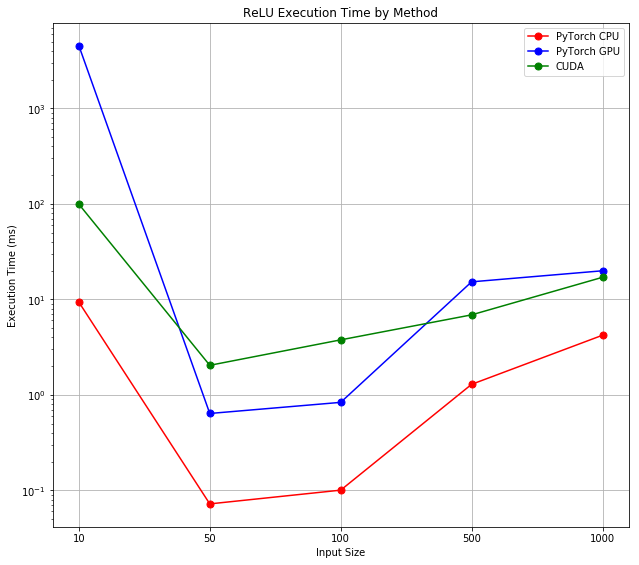

In [3]:
# relu time profiling example

# define timing lists
time_pytorch_cpu = []
time_pytorch_gpu = []
time_cuda = []

for input_size in INPUT_SIZES:
    
    time_pytorch_cpu_total = 0
    time_pytorch_gpu_total = 0
    time_cuda_total = 0
    
    # average execution times for more stable and accurate results
    for _ in range(iterations):
    
        # define input array
        input_array = np.random.randint(-10, high=10, size=(input_size, input_size))

        # define PyTorch input array
        input_array_pytorch_cpu = torch.from_numpy(input_array)

        # profile CPU PyTorch
        pytorch_cpu_start = time.time()
        output_array_pytorch_cpu = F.relu(input_array_pytorch_cpu)
        pytorch_cpu_end = time.time()

        # add pytorch CPU time to list
        time_pytorch_cpu_total += (pytorch_cpu_end - pytorch_cpu_start) * 1000

        # profile GPU PyTorch (including memory transfer)
        pytorch_gpu_start = time.time()
        input_array_pytorch_gpu = input_array_pytorch_cpu.to(device)
        output_array_pytorch_gpu = F.relu(input_array_pytorch_gpu)
        output_array_pytorch_gpu = output_array_pytorch_gpu.cpu()
        pytorch_gpu_end = time.time()

        # add pytorch GPU time to list
        time_pytorch_gpu_total += (pytorch_gpu_end - pytorch_gpu_start) * 1000

        # profile CUDA (including memory transfer)
        cuda_start = time.time()
        cuda_output = cuda_functions.relu(input_array)
        cuda_end = time.time()

        # add CUDA time to list
        time_cuda_total += (cuda_end - cuda_start) * 1000
        
    time_pytorch_cpu.append(time_pytorch_cpu_total / iterations)
    time_pytorch_gpu.append(time_pytorch_gpu_total / iterations)
    time_cuda.append(time_cuda_total / iterations)

# plot times
title = "ReLU Execution Time by Method"
plot_execution_times(time_pytorch_cpu, time_pytorch_gpu, time_cuda, title)


### Discuss the results of the relu() time profile:

#### 1. Are the GPU implementations faster than PyTorch CPU implementation? Why or why not?

TODO: Your answer here

No, GPU implementation is not faster than CPU implementation. 

First, CPU is much more faster than single GPU thread.

Second, the calculation of ReLu is too simple so most of the time is spent on transferring data between host memory and device memory. If the calculation can be more complicated, then the portion of transfering data will be trivial and make the GPU calculation faster than CPU.

#### 2. How does our CUDA implementation or ReLU compare to PyTorch's GPU implementation?

TODO: Your answer here

The a mount of time they take is very similar to each other.

#### 3. Based on 1, is it worth computing ReLU activation by itself on GPU? If not, why is this function still needed for GPU deep learning implementations?

TODO: 

No.

The reason why GPU ReLu is slower is because it spend most of the time on transfering data. In deep learning, ReLu as an activation function always follows layers such as dense or cnn layer. Those layer can be accelerated by GPU and the data already resides in the device memory, so relu on device doesn't waste time on transferring data.

### Timing of 2D Convolution, 2D Max-Pooling, and Fully Connected layers

TODO: Using the relu time profile as an example, generate time profile plots using **plot_execution_times()** for **conv2d()**, **MaxPool2d()**, and **linear()**. Each CUDA implementation function should be compared to the corresponding CPU and GPU implementations in PyTorch. 

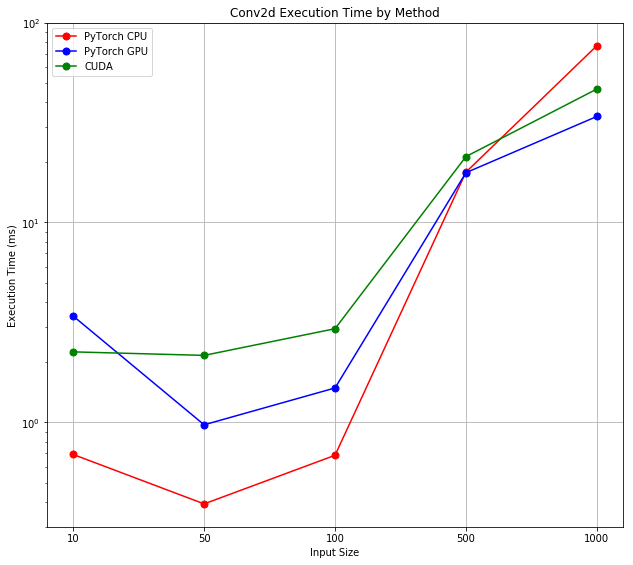

In [10]:
# TODO: conv2d() time profile and plot. You may define any mask shape.

# define timing lists
time_pytorch_cpu = []
time_pytorch_gpu = []
time_cuda = []

mask_size = 3

for input_size in INPUT_SIZES:
    
    time_pytorch_cpu_total = 0
    time_pytorch_gpu_total = 0
    time_cuda_total = 0
    
    # average execution times for more stable and accurate results
    for _ in range(iterations):
    
        # define input array
        input_array = np.random.rand(input_size, input_size)
        mask = np.random.rand(mask_size, mask_size)

        # define PyTorch input array
        torch_input = torch.from_numpy(input_array).unsqueeze(dim=0).unsqueeze(dim=0)
        torch_mask = torch.from_numpy(mask).unsqueeze(dim=0).unsqueeze(dim=0)
        
        # profile CPU PyTorch
        pytorch_cpu_start = time.time()
        output_array_pytorch_cpu = F.conv2d(torch_input, torch_mask, padding='same')
        pytorch_cpu_end = time.time()

        # add pytorch CPU time to list
        time_pytorch_cpu_total += (pytorch_cpu_end - pytorch_cpu_start) * 1000

        # profile GPU PyTorch (including memory transfer)
        pytorch_gpu_start = time.time()
        torch_input_d = torch_input.to(device)
        torch_mask_d = torch_mask.to(device)
        output_array_pytorch_gpu = F.conv2d(torch_input_d, torch_mask_d, padding='same')
        output_array_pytorch_gpu = output_array_pytorch_gpu.cpu()
        pytorch_gpu_end = time.time()

        # add pytorch GPU time to list
        time_pytorch_gpu_total += (pytorch_gpu_end - pytorch_gpu_start) * 1000

        # profile CUDA (including memory transfer)
        cuda_start = time.time()
        cuda_output = cuda_functions.conv2d(input_array, mask)
        cuda_end = time.time()

        # add CUDA time to list
        time_cuda_total += (cuda_end - cuda_start) * 1000
        
    time_pytorch_cpu.append(time_pytorch_cpu_total / iterations)
    time_pytorch_gpu.append(time_pytorch_gpu_total / iterations)
    time_cuda.append(time_cuda_total / iterations)

# plot times
title = "Conv2d Execution Time by Method"
plot_execution_times(time_pytorch_cpu, time_pytorch_gpu, time_cuda, title)

### Discuss the results of the conv2d() time profile.

TODO: Your discussion here

When the size of input array is small, CPU implementation is much faster than GPU implementations. Because the CPU is much faster than GPUs and don't need time for transferring data between host and device.

As the size of input array increases, the GPU implementations become faster than CPU because the number of operations in each thread become larger and transferring time only take small portion of it.

The CUDA implementation is slower than the Pytorch implementation. Because for this assignment I only used naive implementation which means that the array is constantly accessed from the global memory of the device. That can be optimized by using shared memory and constant memory, also the way of arranging the block and grid size and loading data can be important as well. There's another way of implementing convolution by transform the convolution to matrix multiplication and parallelize it. To my knowledge this is the fastest implementation of convolution.


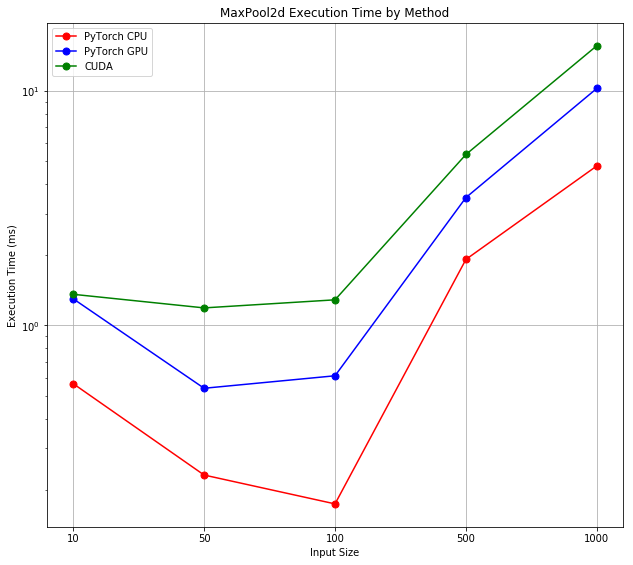

In [11]:
# TODO: MaxPool2d() time profile and plot. You may use any pooling kernel size.

# define timing lists
time_pytorch_cpu = []
time_pytorch_gpu = []
time_cuda = []

kernel_size = 3

torch_MaxPool2d = torch.nn.MaxPool2d(kernel_size, stride=kernel_size)

for input_size in INPUT_SIZES:
    
    time_pytorch_cpu_total = 0
    time_pytorch_gpu_total = 0
    time_cuda_total = 0
    
    # average execution times for more stable and accurate results
    for _ in range(iterations):
    
        # define input array
        input_array = np.random.rand(input_size, input_size).astype(np.float32)

        # define PyTorch input array
        torch_input = torch.from_numpy(input_array).unsqueeze(dim=0)
        
        # profile CPU PyTorch
        pytorch_cpu_start = time.time()
        output_array_pytorch_cpu = torch_MaxPool2d(torch_input)
        pytorch_cpu_end = time.time()

        # add pytorch CPU time to list
        time_pytorch_cpu_total += (pytorch_cpu_end - pytorch_cpu_start) * 1000

        # profile GPU PyTorch (including memory transfer)
        pytorch_gpu_start = time.time()
        torch_input_d = torch_input.to(device)
        output_array_pytorch_gpu = torch_MaxPool2d(torch_input_d)
        output_array_pytorch_gpu = output_array_pytorch_gpu.cpu()
        pytorch_gpu_end = time.time()

        # add pytorch GPU time to list
        time_pytorch_gpu_total += (pytorch_gpu_end - pytorch_gpu_start) * 1000

        # profile CUDA (including memory transfer)
        cuda_start = time.time()
        cuda_output = cuda_functions.MaxPool2d(input_array, kernel_size=kernel_size)
        cuda_end = time.time()

        # add CUDA time to list
        time_cuda_total += (cuda_end - cuda_start) * 1000
        
    time_pytorch_cpu.append(time_pytorch_cpu_total / iterations)
    time_pytorch_gpu.append(time_pytorch_gpu_total / iterations)
    time_cuda.append(time_cuda_total / iterations)

# plot times
title = "MaxPool2d Execution Time by Method"
plot_execution_times(time_pytorch_cpu, time_pytorch_gpu, time_cuda, title)

### Discuss the results of the MaxPool2d() time profile.

TODO: Your discussion here

The MaxPool2d does not require heavy computation so the GPU implementation is slower than the CPU implementation.

The CUDA implementation is slower than Pytorch implementation because the pooling function I wrote is naive implementation. It can be optimized.

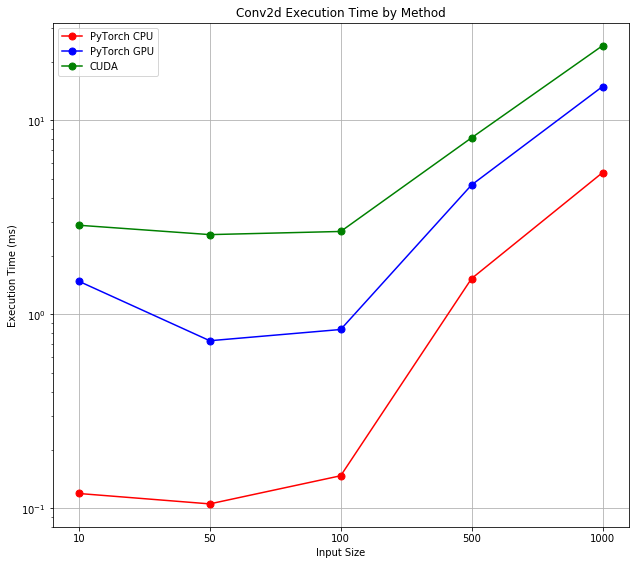

In [17]:
# TODO: linear() time profile and plot. Define weight and bias shapes corresponding 
#       to the input size

# define timing lists
time_pytorch_cpu = []
time_pytorch_gpu = []
time_cuda = []

for input_size in INPUT_SIZES:
    
    time_pytorch_cpu_total = 0
    time_pytorch_gpu_total = 0
    time_cuda_total = 0
    
    # average execution times for more stable and accurate results
    for _ in range(iterations):
    
        # define input array
        input_array = np.random.rand(input_size)
        weights = np.random.rand(input_size, input_size)
        bias = np.random.rand(input_size)

        # define PyTorch input array
        torch_input = torch.from_numpy(input_array).unsqueeze(dim=0).unsqueeze(dim=0)
        torch_weights = torch.from_numpy(weights)
        torch_bias = torch.from_numpy(bias)
        
        # profile CPU PyTorch
        pytorch_cpu_start = time.time()
        output_array_pytorch_cpu = F.linear(torch_input, torch_weights, bias=torch_bias)
        pytorch_cpu_end = time.time()

        # add pytorch CPU time to list
        time_pytorch_cpu_total += (pytorch_cpu_end - pytorch_cpu_start) * 1000

        # profile GPU PyTorch (including memory transfer)
        pytorch_gpu_start = time.time()
        torch_input_d = torch_input.to(device)
        torch_weights_d = torch_weights.to(device)
        torch_bias_d = torch_bias.to(device)
        output_array_pytorch_gpu = F.linear(torch_input, torch_weights, bias=torch_bias)
        output_array_pytorch_gpu = output_array_pytorch_gpu.cpu()
        pytorch_gpu_end = time.time()

        # add pytorch GPU time to list
        time_pytorch_gpu_total += (pytorch_gpu_end - pytorch_gpu_start) * 1000

        # profile CUDA (including memory transfer)
        cuda_start = time.time()
        cuda_output = cuda_functions.linear(input_array, weights, bias)
        cuda_end = time.time()

        # add CUDA time to list
        time_cuda_total += (cuda_end - cuda_start) * 1000
        
    time_pytorch_cpu.append(time_pytorch_cpu_total / iterations)
    time_pytorch_gpu.append(time_pytorch_gpu_total / iterations)
    time_cuda.append(time_cuda_total / iterations)

# plot times
title = "Conv2d Execution Time by Method"
plot_execution_times(time_pytorch_cpu, time_pytorch_gpu, time_cuda, title)

### Discuss the results of the linear() time profile.

TODO: Your discussion here

The CPU implementation is faster than GPU implementations. Pytorch implementation is faster than CUDA implementation.

The sizes of input arrays are not large so not good for parallel implementation. If we can continue increase the size of input array it may show a different result.

The CUDA implementation is a conbination of "transpose", "dot" and "add", it requires constantly transfer data between host and device. We can write another function and only transfer data once and complete all those operations on device before transfer it back to the host to optimize the performance.